# Quickstart: Graph Databases in Python
### Working with Neo4j and NetworkX

Graph databases are a powerful tool for modeling complex relationships, detecting trends across networks, and querying information in ways simply unachievable with traditional relational databases.

At present, Neo4j is the industry leading graph database engine, utilizing the flexible and intuitive <em>Cypher</em> language to run sophisticated queries. Neo4j excels at storing and interacting with large scale graph databases.

That said, Neo4j is an imperfect product. Its documentation is often disjointed and opaque--particularly if you are looking to connect to a graph via Python or R. Major changes are frequently implemented without updates to the official guides, and most of the information available on StackOverflow or similar sites is out-of-date after recent changes. I love this platform--and am excited about its future--but its current form isn't exactly straightforward.

Neo4j also disappoints as an analysis platform, requiring clunky (and often buggy) commands to run basic algorithms. The recently released Graph Algorithms plugin shows promise, but is currently an inconsistent experience.

To fill in the gaps, I prefer Python's NetworkX module for analysis and the Gephi visualization tool to present results. This is hardly a perfect workflow, but at least its a reliable one.

If you have any questions (or if you find better way of doing this) hit me up at gray.ian.hunter@gmail or on Twitter @IanHGray. I by no means consider myself an expert in graph analysis, but I *do* have a high threshold for pain when it comes to reading documentation.

In [19]:
#Import dependencies
from py2neo import Graph, Node, Relationship
import pandas as pd

In [42]:
#Open connection to the Neo4j graph via bolt. In this case, we're using Neo4j desktop.
graph = Graph("bolt://localhost:7687", auth=('neo4j', 'PASSWORD HERE'))

## Loading Data into Neo4j

First, we'll create some dummy data. In this case, we're looking at bands that spun off from the Yardbirds, one of rock & roll's first power groups and the precursor to Led Zeppelin. (Fun fact, did you know that Eric Clapton is the only triple inductee to the Rock & Roll hall of fame? He was awarded for his work in the Yardbirds, Cream, and as a solo artist.)

In [21]:
dataframe = pd.DataFrame({'Musician':['Eric Clapton','Jeff Beck','Jimmy Page',\
 'Eric Clapton','Ginger Baker','Jack Bruce','Jeff Beck','Tim Bogert','Carmine Appice',\
 'Jimmy Page','Robert Plant','John Paul Jones','John Bonham'],

'Band':['Yardbirds','Yardbirds','Yardbirds','Cream','Cream','Cream',\
'Jeff Beck Group','Jeff Beck Group','Jeff Beck Group','Led Zeppelin','Led Zeppelin',\
'Led Zeppelin','Led Zeppelin'],
                             
'Instrument':['Guitar','Guitar','Guitar','Guitar','Bass','Drums',\
'Guitar','Bass','Drums','Guitar','Vocal','Keyboard','Drums']})

#Lets print the dataframe to see how it looks in tabular form.
print (dataframe)

           Musician             Band Instrument
0      Eric Clapton        Yardbirds     Guitar
1         Jeff Beck        Yardbirds     Guitar
2        Jimmy Page        Yardbirds     Guitar
3      Eric Clapton            Cream     Guitar
4      Ginger Baker            Cream       Bass
5        Jack Bruce            Cream      Drums
6         Jeff Beck  Jeff Beck Group     Guitar
7        Tim Bogert  Jeff Beck Group       Bass
8    Carmine Appice  Jeff Beck Group      Drums
9        Jimmy Page     Led Zeppelin     Guitar
10     Robert Plant     Led Zeppelin      Vocal
11  John Paul Jones     Led Zeppelin   Keyboard
12      John Bonham     Led Zeppelin      Drums


A powerful feature of graph databases is their ability to assign uniqueness to properties.
We call that explicitly here, as there is only one instance of a musician and a band, although they can
have different arrangements.

In [22]:
graph.schema.create_uniqueness_constraint('musician', 'musician_name')
graph.schema.create_uniqueness_constraint('band', 'band_name')

Because this is a relatively small dataset, we can iterate over its elements to insert into the graph.
For larger datasets, it may be necessary to use Neo4j's native data loading procedures.

In [23]:
for index, rows in dataframe.iterrows():
    musician_name = rows['Musician']
    band_name = rows['Band']
    instrument = rows['Instrument']
    
    #Create a Node object with information about the musician. Note that in this newer version of
    #py2neo, we have to explicitly declare primarylabel and primarykey.
    musician = Node('musician', musician_name = musician_name, instrument = instrument)
    musician.__primarylabel__='musician'
    musician.__primarykey__='musician_name'
    
    #Create a Node object for the band
    band = Node('band', band_name = band_name)
    band.__primarylabel__='band'
    band.__primarykey='band_name'
    
    #Create a Relationship object, describing the connection
    PLAYED_IN = Relationship.type("PLAYED_IN")
    
    #Now insert nodes and relationship to the graph
    graph.merge(PLAYED_IN(musician, band), 'musician_name', 'band_name')

Now that the data is stored in Neo4j, we can run cypher queries against it, returning the results as
pandas dataframe. In this case, we'll look for musicians who played in both the Yardbirds and Cream.

In [24]:
neo_df = pd.DataFrame(graph.run(
"MATCH (m:musician)-[:PLAYED_IN]->(y:band {band_name:'Yardbirds'})\
MATCH (m)-[:PLAYED_IN]->(c:band {band_name:'Cream'})\
RETURN m.musician_name, m.instrument").data())
print (neo_df)

  m.instrument m.musician_name
0       Guitar    Eric Clapton


The result is Eric Clapton, because he's the best. But what if we want to add data from another source, which
pairs the bands with the albums they released? 

In [25]:
albums_df = pd.DataFrame({'album':['For Your Love', 'Having a Rave Up with The Yardbirds',\
                                   'Yardbirds', 'Over Under Sideways Down', 'Little Games',\
                                 'Fresh Cream', 'Disraeli Gears', 'Wheels of Fire', 'Goodbye',\
                                 'Led Zeppelin', 'Led Leppelin II', 'Led Zeppelin III',\
                                   'Led Zeppelin IV', 'Houses of the Holy', 'Physical Graffiti',\
                                 'Presence', 'In Through the Out Door', 'Truth', 'Beck-Ola', 'Rough and Ready',\
                                  'Jeff Beck Group'],
                        'year':[1965, 1965, 1966, 1966, 1967, 1966, 1967, 1968, 1969,\
                               1969, 1969, 1970, 1971, 1973, 1975, 1976, 1979, 1968, 1969, 1971, 1972],
                          
                        'band':['Yardbirds', 'Yardbirds', 'Yardbirds', 'Yardbirds', 'Yardbirds',\
                               'Cream', 'Cream', 'Cream', 'Cream', 'Led Zeppelin', 'Led Zeppelin',\
                                'Led Zeppelin', 'Led Zeppelin', 'Led Zeppelin', 'Led Zeppelin',\
                               'Led Zeppelin', 'Led Zeppelin', 'Jeff Beck Group', 'Jeff Beck Group',\
                               'Jeff Beck Group', 'Jeff Beck Group']})
print(albums_df)

                                  album  year             band
0                         For Your Love  1965        Yardbirds
1   Having a Rave Up with The Yardbirds  1965        Yardbirds
2                             Yardbirds  1966        Yardbirds
3              Over Under Sideways Down  1966        Yardbirds
4                          Little Games  1967        Yardbirds
5                           Fresh Cream  1966            Cream
6                        Disraeli Gears  1967            Cream
7                        Wheels of Fire  1968            Cream
8                               Goodbye  1969            Cream
9                          Led Zeppelin  1969     Led Zeppelin
10                      Led Leppelin II  1969     Led Zeppelin
11                     Led Zeppelin III  1970     Led Zeppelin
12                      Led Zeppelin IV  1971     Led Zeppelin
13                   Houses of the Holy  1973     Led Zeppelin
14                    Physical Graffiti  1975     Led Z

We can merge the above dataset into the graph using the same technique as before.
The MERGE operation will check to see if a node already exists, and then connect new data to it, or it will
create a new node.

In [26]:
graph.schema.create_uniqueness_constraint('album', 'album_name')

for index, rows in albums_df.iterrows():
    album_name = rows['album']
    band_name = rows['band']
    year = rows['year']
    
    band = Node('band', band_name = band_name)
    band.__primarylabel__='band'
    band.__primarykey__='band_name'
    
    album = Node('album', album_name = album_name, year = year)
    album.__primarylabel__='album'
    album.__primarykey__='album_name'
    
    RELEASED = Relationship.type("RELEASED")
    
    graph.merge(RELEASED(band, album), 'band_name', 'album')

The final product should look like this:

In [27]:
%%html
<img src="yardbirds_network.png", width = 1000, height=800>

Using Cypher, we can calculate basic statistics about the network, for instance, the musicians who have the greatest number
of connections within the dataset:

In [28]:
degree_df = pd.DataFrame(graph.run("MATCH (m:musician)\
                            RETURN m.musician_name as musician, size((m)-[]-()) AS degree\
                            ORDER BY degree DESC").data())
print(degree_df)

   degree         musician
0       2     Eric Clapton
1       2        Jeff Beck
2       2       Jimmy Page
3       1     Ginger Baker
4       1       Jack Bruce
5       1       Tim Bogert
6       1   Carmine Appice
7       1     Robert Plant
8       1  John Paul Jones
9       1      John Bonham


## Exporting Neo4j to NetworkX

Now that our data is stored in Neo4j, we can take full advantage of its storage and querying capabilities. However, if we want to run more advanced analysis or create more customized visualizations, it is often best to pull the data out of the Neo4j environment.

Unfortunately, there is no particularly elegant way to accomplish this. (Yes, there are some *theoretical* options you can find on github, but they seem to be more trouble than they're worth.) The best bet is to pull relevant data out of Neo4j as a Pandas DataFrame object, then reconstruct the graph in NetworkX. 

(For smaller/straightforward datasets, you can probably skip Neo4j entirely and just run everything in NetworkX. Neo4j is best used in situations where you're storing lots of data, or need advanced querying options.)

In [29]:
#Import dependencies
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

We'll start by reading our data out of Neo4j as a Pandas Dataframe object. This can be any query, but in this case we'll just pull everything.

Note that we need to run separate queries for different relationship types. If you have a very complicated graph with many different relationship types, then you have my condolences.

In [30]:
df_musicians = pd.DataFrame(graph.run("MATCH (m:musician)-[:PLAYED_IN]->(b:band)\
                            RETURN m.musician_name as musician, b.band_name as band,\
                            m.instrument as instrument").data())
df_albums = pd.DataFrame(graph.run("MATCH (b:band)-[:RELEASED]->(a:album)\
                                    RETURN b.band_name as band, a.album_name as album, a.year as year").data())

Now load the dataframes into NetworkX. This process is almost identical to loading data into Neo4j. (There *are* more efficient ways of doing this, but for our purposes, we'll use the trusty for-loop).

In [31]:
#Start by creating a blank networkX graph called "G". In this case, we're creating a directional graph (DiGraph).
G = nx.DiGraph()

#As before, iterate over each row in the dataframe and create the nodes and relationships.
#Note that there *is* a nx.from_pandas_dataframe() function that should make this easier, 
#but it doesn't always import properly. Life is suffering.
for index, rows in df_musicians.iterrows():
    musician = rows['musician']
    instrument = rows['instrument']
    band = rows['band']
    
    G.add_node(musician, instrument=instrument, node_type='musician')
    G.add_node(band, node_type='band')
    G.add_edge(musician, band)

#Now do the same with the albums dataframe.
for index, rows in df_albums.iterrows():
    band = rows['band']
    album = rows['album']
    year = rows['year']
    G.add_node(album, node_type='album', year=year)
    G.add_edge(band, album)

#Note that I have created a new node attribute, *node_type*, that wasn't in the Neo4j graph.
#NetworkX doesn't automatically differentiate between node types, so this will be helpful later
#in the visualziation step.

Lets take a quick look at the results.

In [32]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 32
Number of edges: 34
Average in degree:   1.0625
Average out degree:   1.0625


As with Neo4j, we can call out individual nodes to examine their attributes.

In [33]:
print (G.node['Eric Clapton'])

{'instrument': 'Guitar', 'node_type': 'musician'}



## Visualization

Now that our data is loaded, we have a few different choices on how to visualize the graph's structure.

The first option is to use NetworkX's built in graph function, which calls on the Matplotlib library to produce a simple graph. This is useful in situations where we want just a quick glance at our results. 

But <b>*wow*<b> is it ugly.

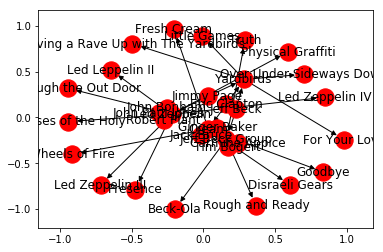

In [34]:
nx.draw_networkx(G)

The pyvis module offers a better option--with the added benefit of interactivity--and requires minimal setup. It includes a helpful "from_nx" function that reads NetworkX graphs, and can then display them as an HTML object in Jupyter. (If the interactive visualization does not appear, try downloading and running this notebook).

In [35]:
from pyvis.network import Network
net = Network(notebook=True, height="750px", width="100%")
net.from_nx(G)
net.show('example.html')

The result should look like this:

In [36]:
%%html
<img src="static_pyvis_graph.png", width = 1000, height=800>

The third, and arguably best option is to export the network data from python and plot the results in Gephi or Cytoscape--two open source network visualization tools designed for this purpose. The following snippet will export the NetworkX graph as a .gexf file, which can be read by Gephi.

In [37]:
nx.write_gexf(G, 'gephi_data.gexf')

## Performing Network Analysis

As shown below, running network analysis in NetworkX is pretty straightforward. We simply call the function on the graph object, and NetworkX returns a dictionary of each node and its associated score.

In [38]:
degree_centrality = nx.degree_centrality(G)
print(degree_centrality)

{'Jimmy Page': 0.06451612903225806, 'Yardbirds': 0.29032258064516125, 'Jeff Beck': 0.06451612903225806, 'Eric Clapton': 0.06451612903225806, 'Jack Bruce': 0.03225806451612903, 'Cream': 0.22580645161290322, 'Ginger Baker': 0.03225806451612903, 'Carmine Appice': 0.03225806451612903, 'Jeff Beck Group': 0.25806451612903225, 'Tim Bogert': 0.03225806451612903, 'John Bonham': 0.03225806451612903, 'Led Zeppelin': 0.4193548387096774, 'John Paul Jones': 0.03225806451612903, 'Robert Plant': 0.03225806451612903, 'Little Games': 0.03225806451612903, 'Over Under Sideways Down': 0.03225806451612903, 'Having a Rave Up with The Yardbirds': 0.03225806451612903, 'For Your Love': 0.03225806451612903, 'Goodbye': 0.03225806451612903, 'Wheels of Fire': 0.03225806451612903, 'Disraeli Gears': 0.03225806451612903, 'Fresh Cream': 0.03225806451612903, 'Rough and Ready': 0.03225806451612903, 'Beck-Ola': 0.03225806451612903, 'Truth': 0.03225806451612903, 'In Through the Out Door': 0.03225806451612903, 'Presence': 0

To make this a little easier to work with, we can run the analysis and return the results in a pandas dataframe, indexed by Node. Below, each of the major centrality scores -- Degree, Betweenness, Closeness, and Eigenvector -- is returned as its own dataframe object.

In [39]:
degree_centrality = pd.DataFrame((nx.degree_centrality(G)).items(), columns = ['Node', 'Degree_Centrality']).set_index('Node')
betweenness_centrality = pd.DataFrame((nx.betweenness_centrality(G)).items(), columns = ['Node', 'Betweenness_Centrality']).set_index('Node')
closeness_centrality = pd.DataFrame((nx.closeness_centrality(G)).items(), columns = ['Node', 'Closeness_Centrality']).set_index('Node')
eigenvector_centrality = pd.DataFrame((nx.eigenvector_centrality(G)).items(), columns = ['Node', 'Eigenvector_Centrality']).set_index('Node')

Now we can combine the dataframes into a single view, and sort based on their degree centrality (or any other metric).

In [40]:
results = degree_centrality.join(betweenness_centrality, how = 'inner').join(closeness_centrality, how ='inner')\
                            .join(eigenvector_centrality, how = 'inner').reset_index()
results = results.sort_values(by=['Degree_Centrality'], ascending = False)
print (results.head())

               Node  Degree_Centrality  Betweenness_Centrality  \
11     Led Zeppelin           0.419355                0.030108   
1         Yardbirds           0.290323                0.012903   
8   Jeff Beck Group           0.258065                0.009677   
5             Cream           0.225806                0.012903   
0        Jimmy Page           0.064516                0.000000   

    Closeness_Centrality  Eigenvector_Centrality  
11              0.129032            2.695824e-01  
1               0.096774            2.156659e-01  
8               0.096774            2.156659e-01  
5               0.096774            4.499142e-07  
0               0.000000            6.427346e-09  


These results make sense, as Led Zeppelin has the most band members in the dataset, and produced the greatest number of albums. Since it has the most connections, it has the highest Degree Centrality. The other bands follow suit, based on the number of members they had and albums they released.

If we instead sort by Eigenvector Centrality, we again find Led Zeppelin at the top, but this time its albums take the next highest places. This is because the Eigenvector algorithm (similar to PageRank) measures the closeness of a given node to other, highly influential nodes.

In [41]:
results = results.sort_values(by=['Eigenvector_Centrality'], ascending = False)
print (results.head())

                       Node  Degree_Centrality  Betweenness_Centrality  \
11             Led Zeppelin           0.419355                0.030108   
25  In Through the Out Door           0.032258                0.000000   
30         Led Zeppelin III           0.032258                0.000000   
28       Houses of the Holy           0.032258                0.000000   
26                 Presence           0.032258                0.000000   

    Closeness_Centrality  Eigenvector_Centrality  
11              0.129032                0.269582  
25              0.089606                0.269582  
30              0.089606                0.269582  
28              0.089606                0.269582  
26              0.089606                0.269582  


And those are the basics. Beautiful and efficient, no, but it'll get the job done for small-to-medium sized projects. Neo4j is making great strides in evangelizing and democratizing graph databases, but there's still a ways to go before it is a frictionless experience.

Also, go check out the Yardbirds.